# 1. Imports

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 2. Loading the dataset

In [14]:
dataset = pd.read_csv("../../data/processed/COEN498-691_HAR_preprocessed_dataset.csv")
df = pd.DataFrame(dataset)

In [15]:
activity_mapper = {
    'sitting': 1,
    'walking': 2,
    'running': 3,
    'lying': 4,
}

In [16]:
# Get the number of features
feature_columns = df.columns.difference(['activity_id', 'participant_id'])
print(f"Number of features in the dataset: {len(feature_columns)}")

Number of features in the dataset: 37


# 3. Training Random Forest classifier (all features)
**Train the model using all features in the original dataset and default hyperparameters. Use Leave-One-Subject-Out (LOSO) cross validation.**

## 3.1. Classification report and confusion matrix

In [17]:
groups = df['participant_id']
feature_columns = df.columns.difference(['participant_id', 'activity_id'])
activity_labels = sorted(df['activity_id'].unique())
gkf = GroupKFold(n_splits=5) 

Results for YL
Accuracy: 1.0000
Classification report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       234
           2       1.00      1.00      1.00       234
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       244

    accuracy                           1.00       957
   macro avg       1.00      1.00      1.00       957
weighted avg       1.00      1.00      1.00       957



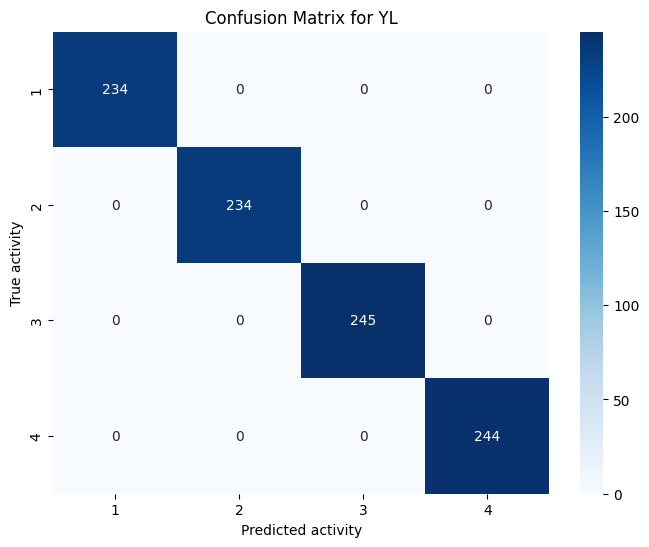

Results for ZM
Accuracy: 0.9843
Classification report:
              precision    recall  f1-score   support

           1       0.94      1.00      0.97       253
           2       1.00      1.00      1.00       229
           3       1.00      1.00      1.00       234
           4       1.00      0.94      0.97       238

    accuracy                           0.98       954
   macro avg       0.99      0.98      0.98       954
weighted avg       0.99      0.98      0.98       954



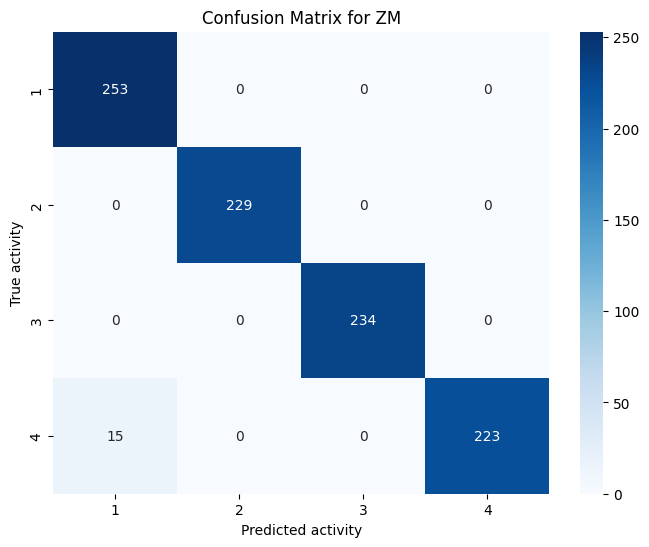

Results for YT
Accuracy: 1.0000
Classification report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       243
           2       1.00      1.00      1.00       237
           3       1.00      1.00      1.00       237
           4       1.00      1.00      1.00       237

    accuracy                           1.00       954
   macro avg       1.00      1.00      1.00       954
weighted avg       1.00      1.00      1.00       954



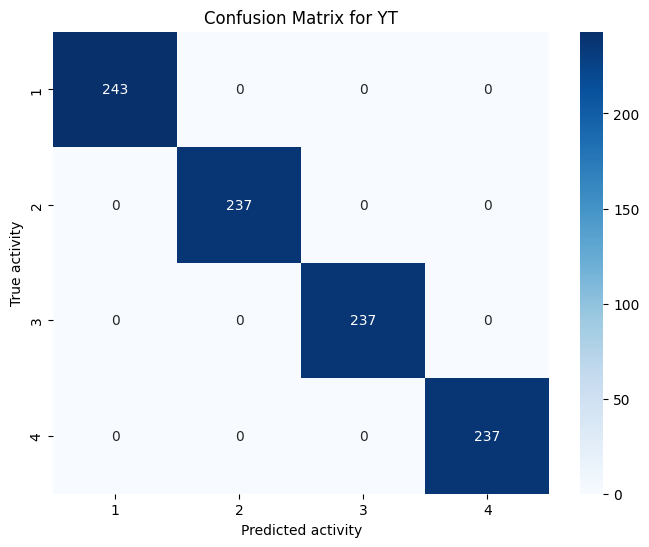

Results for VV
Accuracy: 1.0000
Classification report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       236
           2       1.00      1.00      1.00       235
           3       1.00      1.00      1.00       231
           4       1.00      1.00      1.00       248

    accuracy                           1.00       950
   macro avg       1.00      1.00      1.00       950
weighted avg       1.00      1.00      1.00       950



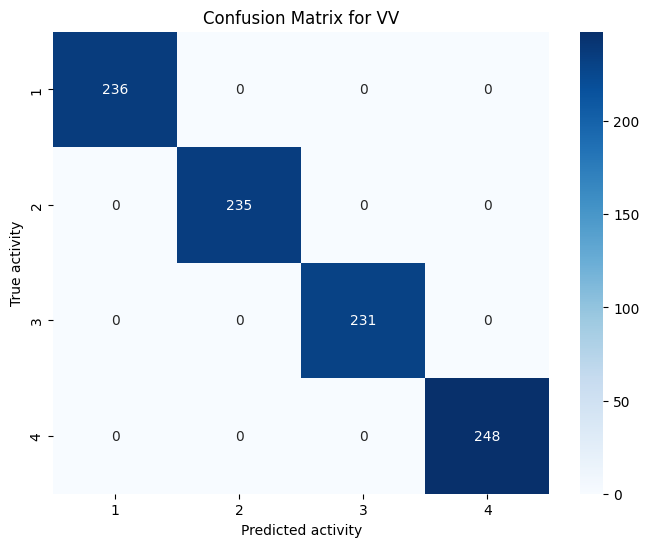

Results for LL
Accuracy: 0.9979
Classification report:
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       239
           2       0.99      1.00      1.00       231
           3       1.00      1.00      1.00       237
           4       1.00      1.00      1.00       229

    accuracy                           1.00       936
   macro avg       1.00      1.00      1.00       936
weighted avg       1.00      1.00      1.00       936



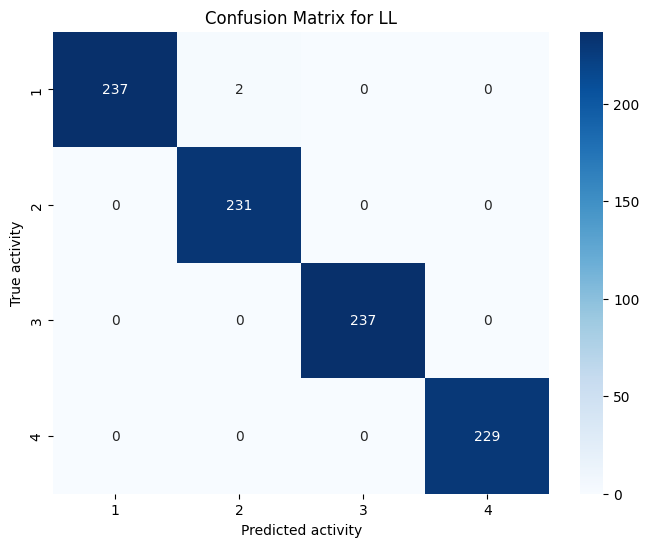

In [18]:
classification_reports = []

for train_index, test_index in gkf.split(df, df['activity_id'], groups):

    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

    X_train = train_set[feature_columns]
    y_train = train_set['activity_id']
    X_test = test_set[feature_columns]
    y_test = test_set['activity_id']

    test_participant_id = test_set['participant_id'].iloc[0]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports.append(report)
    print(f"Results for {test_participant_id}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=activity_labels, columns=activity_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {test_participant_id}')
    plt.xlabel('Predicted activity')
    plt.ylabel('True activity')
    plt.show() 


## 3.2. Average weighted F1-score

In [19]:
def print_avg_weighted_f1_score(classification_reports):
    avg_f1 = np.mean([report['weighted avg']['f1-score'] for report in classification_reports])
    print(f"Average Weighted F1 Score: {avg_f1:.4f}")

In [20]:
print_avg_weighted_f1_score(classification_reports)

Average Weighted F1 Score: 0.9964


## 3.3 Observations

The average weighted F1 score is quite high (above 0.99). Default parameters provided a satisfying model. Parameter tuning is slow and further performance gain is not necessary; no further tuning will be performed on the random forest. Instead, we will investigate the following:  
1. Which features does the random forest model prioritize?
2. What happens if we remove some features from the dataset?

# Experiment 1: Investigate feature importance
**Investigate which features are prioritized by the random forest model.**

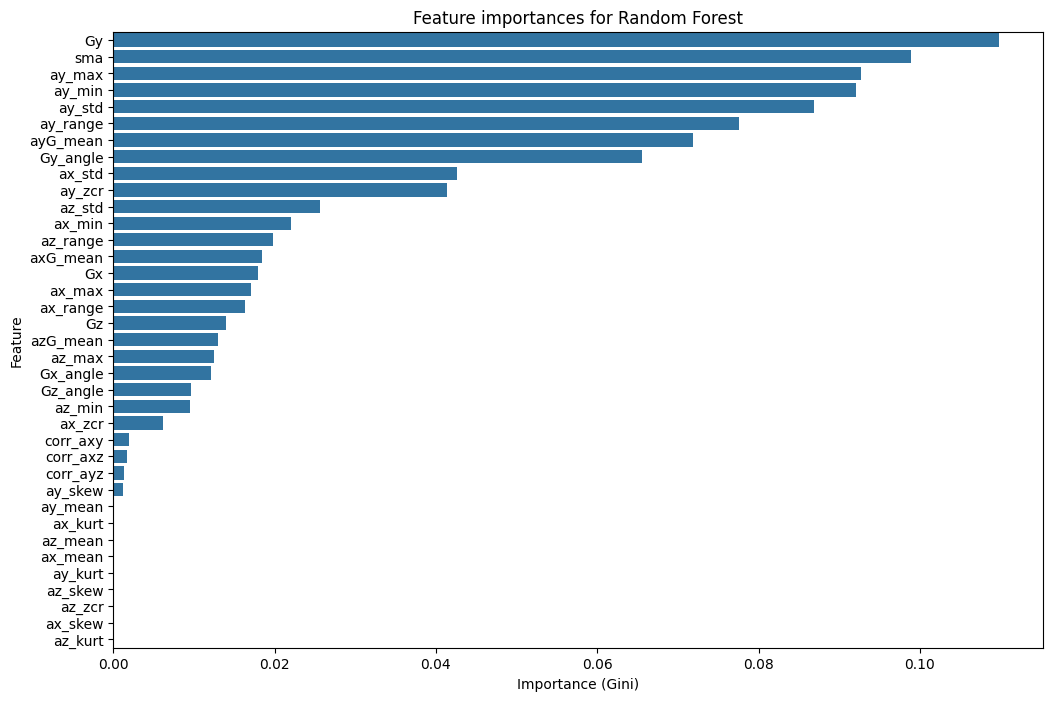

In [21]:
ft_importances = rf.feature_importances_
ft_importance_df = pd.DataFrame({'Feature': feature_columns, 'Importance': ft_importances})
ft_importance_df = ft_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=ft_importance_df)
plt.title('Feature importances for Random Forest')
plt.xlabel('Importance (Gini)')
plt.ylabel('Feature')
plt.show()

## Experiment 1: Observations
Random forest prioritizes (Gini > 0.6):
- Gy, 
- sma, 
- ay_max, 
- ay_min, 
- ay_std, 
- ay_range, 
- ayG_mean, 
- Gy_angle   
  
We can see that **features extracted from the accelerometer y axis completely dominate those extracted from other axes**. The y axis seems to be very important for the model to recognize the activity.

# Experiment 2: Removing features from the dataset
**Investigate what happens when some features are removed from the dataset.**

Accuracy: 1.0000
Results for YL with reduced features


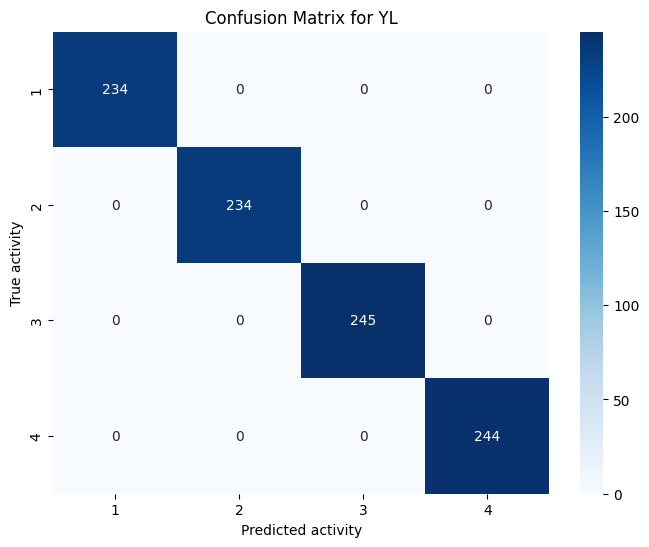

Accuracy: 1.0000
Results for ZM with reduced features


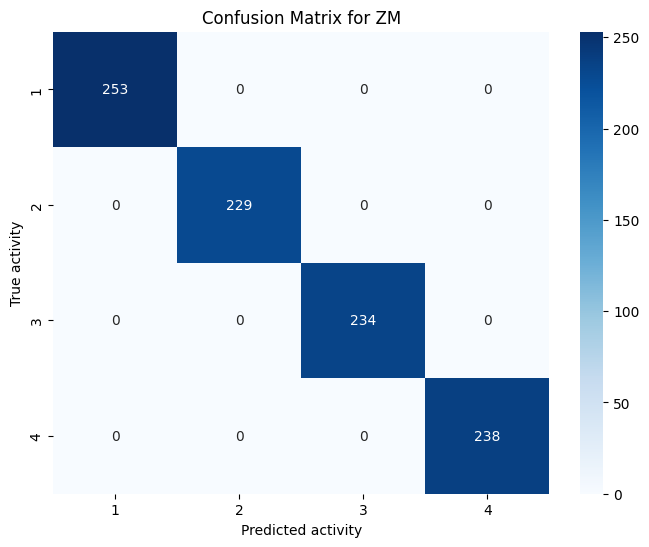

Accuracy: 0.9979
Results for YT with reduced features


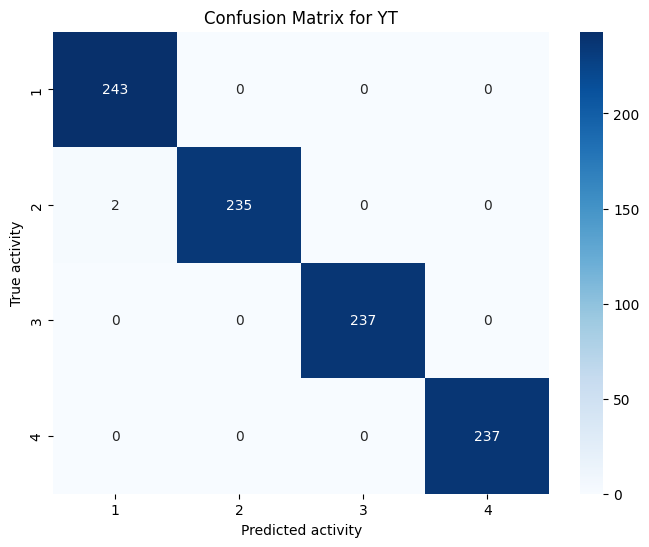

Accuracy: 1.0000
Results for VV with reduced features


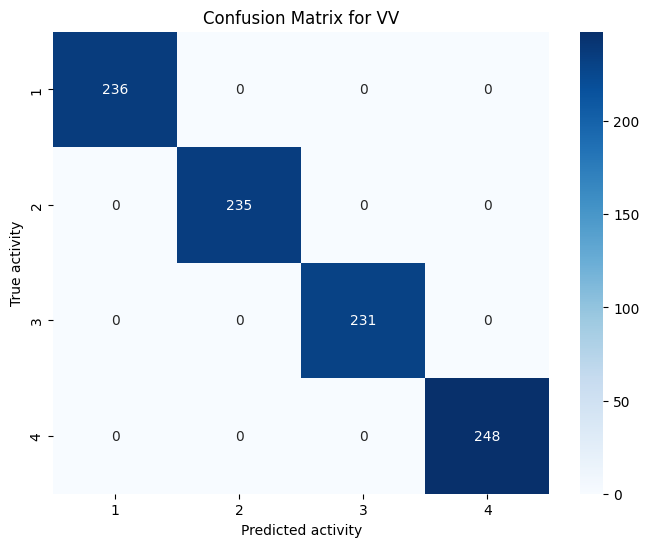

Accuracy: 0.9979
Results for LL with reduced features


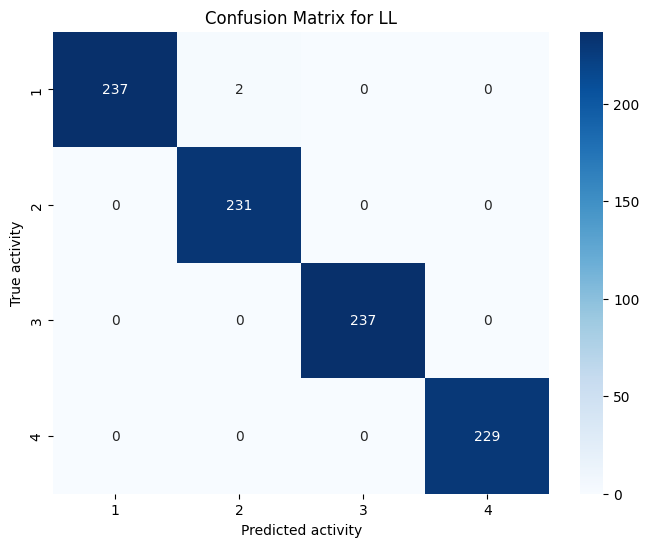

In [23]:
# Keeping the 5 most important features
reduced_feature_columns = ft_importance_df['Feature'].iloc[:-32].values

classification_reports_reduced = []

for train_index, test_index in gkf.split(df, df['activity_id'], groups):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

    X_train = train_set[reduced_feature_columns]
    y_train = train_set['activity_id']
    X_test = test_set[reduced_feature_columns]
    y_test = test_set['activity_id']

    test_participant_id = test_set['participant_id'].iloc[0]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports_reduced.append(report)
    print(f"Results for {test_participant_id} with reduced features")

        # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=activity_labels, columns=activity_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {test_participant_id}')
    plt.xlabel('Predicted activity')
    plt.ylabel('True activity')
    plt.show() 

In [24]:
print_avg_weighted_f1_score(classification_reports_reduced)

Average Weighted F1 Score: 0.9992


Accuracy: 0.7586
Results for YL with reduced features


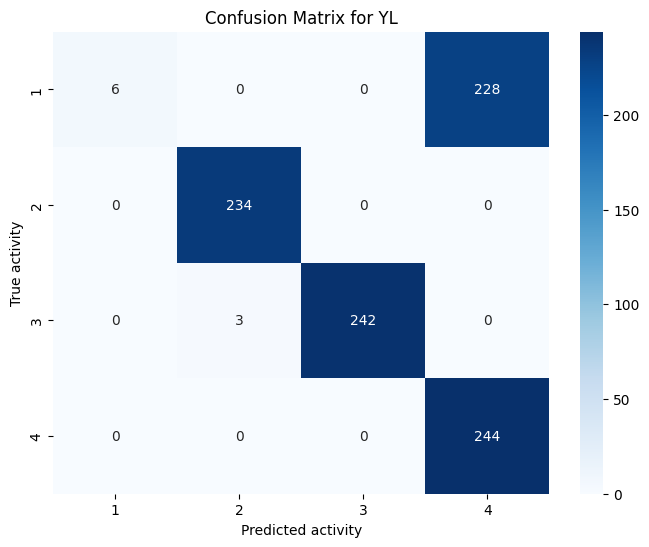

Accuracy: 0.7442
Results for ZM with reduced features


c:\Users\laber\Desktop\COEN691\Project\ML_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\laber\Desktop\COEN691\Project\ML_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\laber\Desktop\COEN691\Project\ML_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

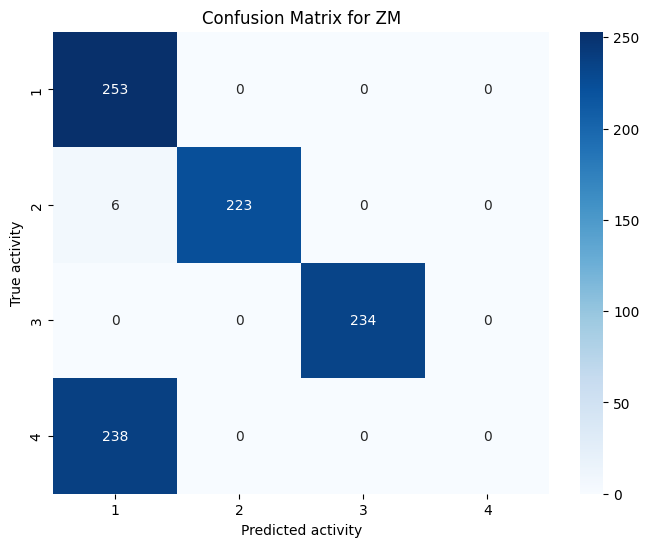

Accuracy: 0.9801
Results for YT with reduced features


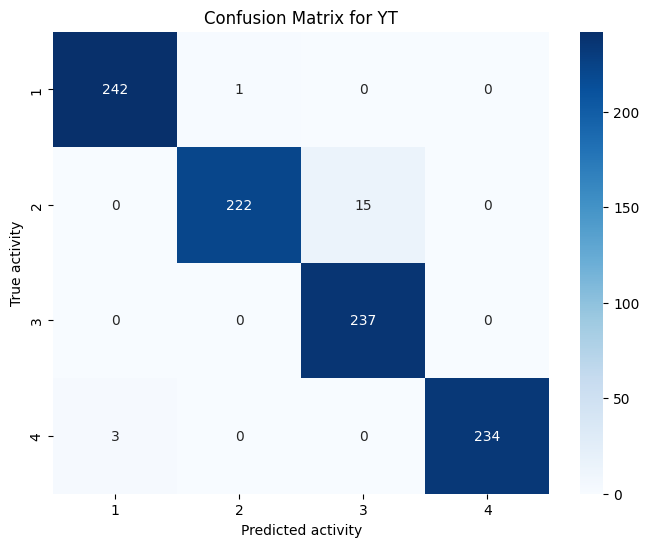

Accuracy: 0.9579
Results for VV with reduced features


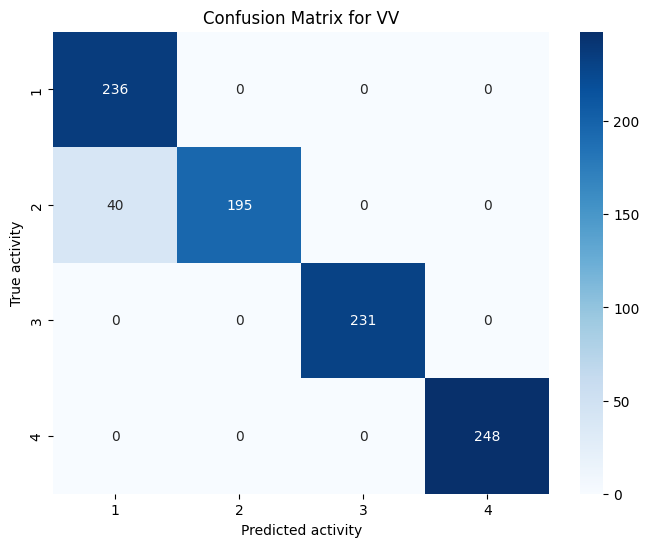

Accuracy: 0.9786
Results for LL with reduced features


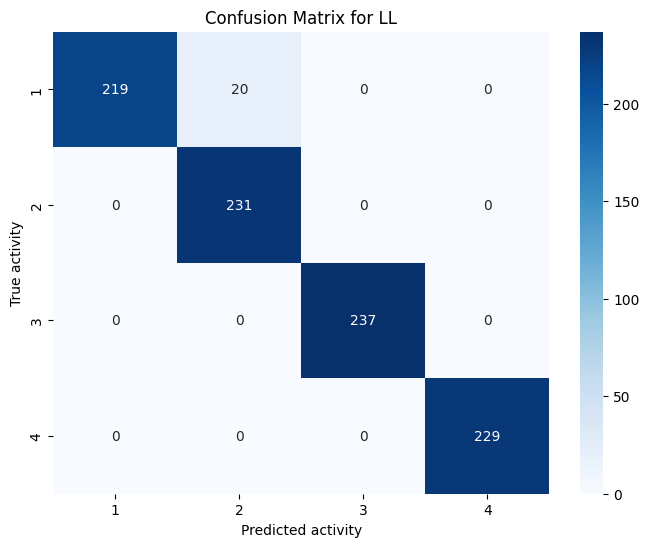

In [30]:
# remove the 10 most important features
reduced_feature_columns = ft_importance_df['Feature'].iloc[10:].values
classification_reports_reduced = []

for train_index, test_index in gkf.split(df, df['activity_id'], groups):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

    X_train = train_set[reduced_feature_columns]
    y_train = train_set['activity_id']
    X_test = test_set[reduced_feature_columns]
    y_test = test_set['activity_id']

    test_participant_id = test_set['participant_id'].iloc[0]

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports_reduced.append(report)
    print(f"Results for {test_participant_id} with reduced features")

        # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=activity_labels, columns=activity_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {test_participant_id}')
    plt.xlabel('Predicted activity')
    plt.ylabel('True activity')
    plt.show()

In [31]:
print_avg_weighted_f1_score(classification_reports_reduced)

Average Weighted F1 Score: 0.8521


## Experiment 2: Observations

The model performance slightly improved by leaving in only the 5 most important features (dropping the 32 least important features). This seems to indicate that a small subset of features have a strong predictive ability.

After removing the 10 most important features, the average weighted f1 score dropped from 0.99 to 0.85. The model almost completely missclassifies sitting or lying down for two participants. The model tends to sometimes confuse walking and sitting, or walking and running. Finding predictive features from accelerometer data (from feature extraction/engineering) seems to have a significant impact on the model performance (up to 0.14 in this short experiment).

# Experiment 3: Examining features

**Investigate the overall distinctness of activities by plotting important features.**

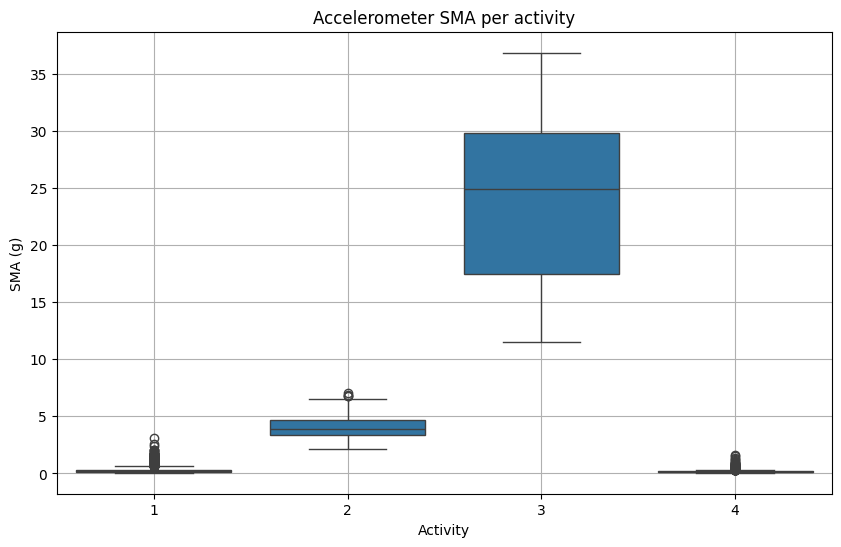

In [6]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='activity_id', y='sma', data=df)
plt.title('Accelerometer SMA per activity')
plt.xlabel('Activity')
plt.ylabel('SMA (g)')
plt.grid(True)
plt.show()

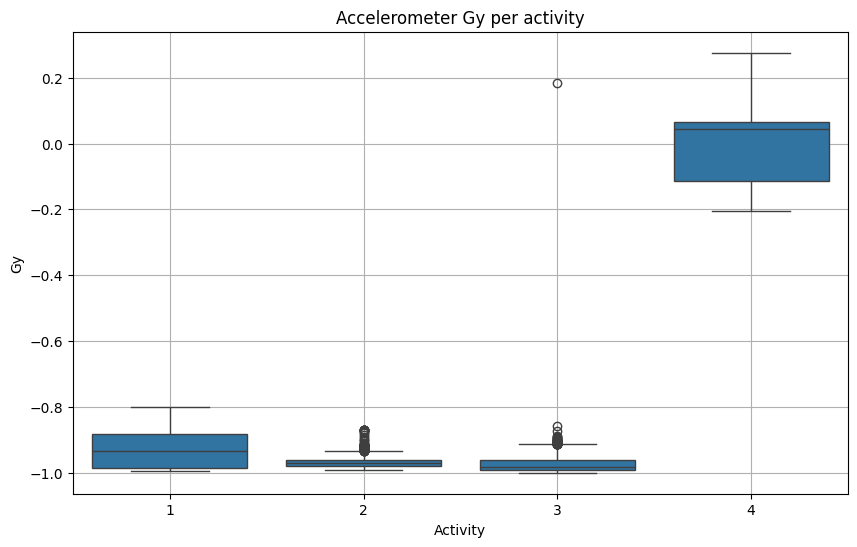

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='activity_id', y='Gy', data=df)
plt.title('Accelerometer Gy per activity')
plt.xlabel('Activity')
plt.ylabel('Gy')
plt.grid(True)
plt.show()

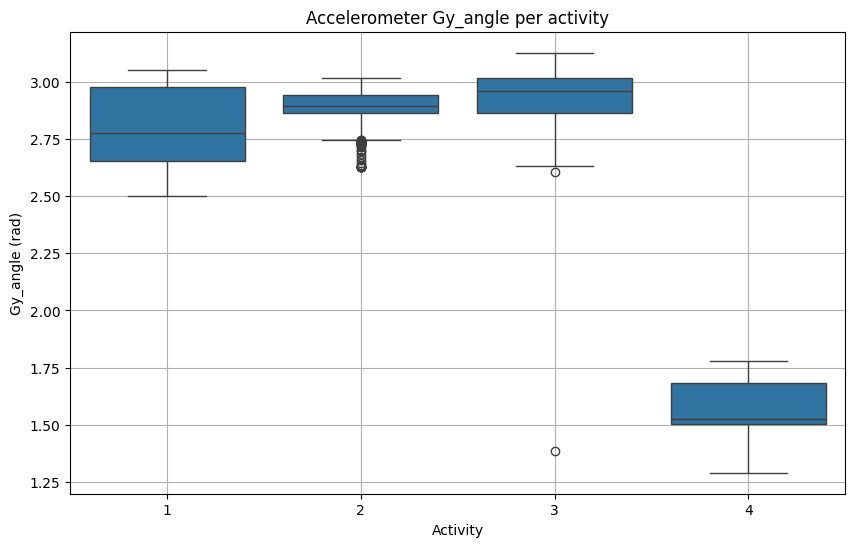

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='activity_id', y='Gy_angle', data=df)
plt.title('Accelerometer Gy_angle per activity')
plt.xlabel('Activity')
plt.ylabel('Gy_angle (rad)')
plt.grid(True)
plt.show()

## Observations

While there does not seem to be a single feature that would allow the classifier to distinguish between all activities, having a good combination of features 